# **Homework 8 - Anomaly Detection**

If there are any questions, please contact mlta-2022spring-ta@googlegroups.com

Slide:    [Link]()　Kaggle: [Link](https://www.kaggle.com/c/ml2022spring-hw8)

# Set up the environment


In [1]:
Numbering = 40
logToWandb = False
if logToWandb: 
    import wandb

# Import packages

In [2]:
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torch.optim import Adam, AdamW
from qqdm import qqdm, format_str
import pandas as pd

# Loading data

In [3]:

train = np.load('data/trainingset.npy', allow_pickle=True)
test = np.load('data/testingset.npy', allow_pickle=True)

print(train.shape)
print(test.shape)

(100000, 64, 64, 3)
(19636, 64, 64, 3)


## Random seed
Set the random seed to a certain value for reproducibility.

In [4]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# myseed = random.randint(0, 1000)
myseed = 291
same_seeds(myseed)

# Autoencoder

# Models & loss

In [5]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 1000),
            nn.ReLU(), 
            nn.Linear(1000, 500),
            nn.ReLU(), nn.ReLU(), 
            nn.Linear(500, 250),
            nn.ReLU(), 
            nn.Linear(250, 125),
            nn.ReLU(), 
            nn.Linear(125, 80),
            nn.ReLU(), 
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(80, 125),
            nn.ReLU(), 
            nn.Linear(125, 250),
            nn.ReLU(), 
            nn.Linear(250, 500),
            nn.ReLU(), 
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, 64 * 64 * 3), 
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 4, 16, stride=2, padding=1),         #in_channels, out_channels, kernel_size
            nn.ReLU(),
#             nn.Conv2d(4, 12, 8, stride=2, padding=1),     
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(12, 4, 8, stride=2, padding=1),
#             nn.ReLU(),
			nn.ConvTranspose2d(4, 3, 16, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=2, padding=1),            
            nn.ReLU(),
            nn.Conv2d(16, 128, 4, stride=2, padding=1),    
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),    
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Conv2d(256, 512, 4, stride=2, padding=1),  
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), 
            nn.ReLU(),
			nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1), 
            nn.Tanh(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD

# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [6]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        
        self.transform = transforms.Compose([
          transforms.Lambda(lambda x: x.to(torch.float32)),
          transforms.Lambda(lambda x: 2. * x/255. - 1.),
        ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.tensors)

# Training

## Configuration


In [7]:
# Training hyperparameters
num_epochs = 80
batch_size = 400
learning_rate = 1e-3

# Build training dataloader
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Model
model_type = 'fcn'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes = {'fcn': fcn_autoencoder(), 'cnn': conv_autoencoder(), 'vae': VAE()}
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
model

fcn_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=12288, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
    (4): ReLU()
    (5): Linear(in_features=500, out_features=250, bias=True)
    (6): ReLU()
    (7): Linear(in_features=250, out_features=125, bias=True)
    (8): ReLU()
    (9): Linear(in_features=125, out_features=80, bias=True)
    (10): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=80, out_features=125, bias=True)
    (1): ReLU()
    (2): Linear(in_features=125, out_features=250, bias=True)
    (3): ReLU()
    (4): Linear(in_features=250, out_features=500, bias=True)
    (5): ReLU()
    (6): Linear(in_features=500, out_features=1000, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1000, out_features=12288, bias=True)
    (9): Tanh()
  )
)

## Training loop

In [9]:
if logToWandb:
    wandb.init(
        # Set the project where this run will be logged
        project="ML2022Spring_HW8",
        name= '{}{} {} e={} b={} lr={}'.format(model_type, Numbering, myseed, num_epochs, batch_size, learning_rate),
    )

In [10]:

best_loss = np.inf
model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))
for epoch in qqdm_train:
    tot_loss = list()
    for data in train_dataloader:

        # ===================loading=====================
        img = data.float().cuda()
        if model_type in ['fcn']:
            img = img.view(img.shape[0], -1)

        # ===================forward=====================
        output = model(img)
        if model_type in ['res']:
            output = decoder(output)
            
#         print(output.shape)
        
        if model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)

        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_{}.pt'.format(model_type))
    # ===================log========================
    qqdm_train.set_infos({
        'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
        'loss': f'{mean_loss:.4f}',
    })
    if logToWandb:
        wandb.log({'loss': mean_loss, 'epoch':epoch})
    # ===================save_last========================
    torch.save(model, 'last_model_{}.pt'.format(model_type))

 Iters    Elapsed Time      Speed                                               
 0/80           -             -                                                 
Description   0.0% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 1/80   00:00:07<00:09:55  0.13it/s  1/80   0.1656                              
Description   1.2% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 2/80   00:00:14<00:09:38  0.13it/s  2/80   0.1049                              
Description   2.5% |█                                                          | Iters    Elapsed Time      Speed    epoch   loss                               
 3/80   00:00:22<00:09:29  0.14it/s  3/80   0.0888                              
Description   3.8% |██                                                         | Iters    Elapsed Time      Spee

Description  23.8% |██████████████                                             | Iters    Elapsed Time      Speed    epoch   loss                               
 20/80  00:02:25<00:07:17  0.14it/s  20/80  0.0523                              
Description  25.0% |██████████████                                             | Iters    Elapsed Time      Speed    epoch   loss                               
 21/80  00:02:32<00:07:09  0.14it/s  21/80  0.0518                              
Description  26.2% |███████████████                                            | Iters    Elapsed Time      Speed    epoch   loss                               
 22/80  00:02:40<00:07:02  0.14it/s  22/80  0.0516                              
Description  27.5% |████████████████                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 23/80  00:02:47<00:06:55  0.14it/s  23/80  0.0509                              
Description  28.7% |████████████

Description  42.5% |█████████████████████████                                  | Iters    Elapsed Time      Speed    epoch   loss                               
 35/80  00:04:13<00:05:26  0.14it/s  35/80  0.0469                              
Description  43.8% |█████████████████████████                                  | Iters    Elapsed Time      Speed    epoch   loss                               
 36/80  00:04:20<00:05:18  0.14it/s  36/80  0.0467                              
Description  45.0% |██████████████████████████                                 | Iters    Elapsed Time      Speed    epoch   loss                               
 37/80  00:04:28<00:05:11  0.14it/s  37/80  0.0464                              
Description  46.2% |███████████████████████████                                | Iters    Elapsed Time      Speed    epoch   loss                               
 38/80  00:04:35<00:05:04  0.14it/s  38/80  0.0461                              
Description  47.5% |████████████

Description  58.8% |██████████████████████████████████                         | Iters    Elapsed Time      Speed    epoch   loss                               
 48/80  00:05:46<00:03:50  0.14it/s  48/80  0.0447                              
Description  60.0% |███████████████████████████████████                        | Iters    Elapsed Time      Speed    epoch   loss                               
 49/80  00:05:53<00:03:43  0.14it/s  49/80  0.0445                              
Description  61.3% |████████████████████████████████████                       | Iters    Elapsed Time      Speed    epoch   loss                               
 50/80  00:06:00<00:03:36  0.14it/s  50/80  0.0446                              
Description  62.5% |████████████████████████████████████                       | Iters    Elapsed Time      Speed    epoch   loss                               
 51/80  00:06:07<00:03:29  0.14it/s  51/80  0.0443                              
Description  63.7% |████████████

Description  72.5% |██████████████████████████████████████████                 | Iters    Elapsed Time      Speed    epoch   loss                               
 59/80  00:07:04<00:02:31  0.14it/s  59/80  0.0432                              
Description  73.8% |███████████████████████████████████████████                | Iters    Elapsed Time      Speed    epoch   loss                               
 60/80  00:07:12<00:02:24  0.14it/s  60/80  0.0431                              
Description  75.0% |████████████████████████████████████████████               | Iters    Elapsed Time      Speed    epoch   loss                               
 61/80  00:07:19<00:02:17  0.14it/s  61/80  0.0433                              
Description  76.2% |████████████████████████████████████████████               | Iters    Elapsed Time      Speed    epoch   loss                               
 62/80  00:07:27<00:02:09  0.14it/s  62/80  0.0428                              
Description  77.5% |████████████

Description  85.0% |██████████████████████████████████████████████████         | Iters    Elapsed Time      Speed    epoch   loss                               
 69/80  00:08:17<00:01:19  0.14it/s  69/80  0.0420                              
Description  86.2% |██████████████████████████████████████████████████         | Iters    Elapsed Time      Speed    epoch   loss                               
 70/80  00:08:24<00:01:12  0.14it/s  70/80  0.0419                              
Description  87.5% |███████████████████████████████████████████████████        | Iters    Elapsed Time      Speed    epoch   loss                               
 71/80  00:08:31<00:01:04  0.14it/s  71/80  0.0420                              
Description  88.8% |████████████████████████████████████████████████████       | Iters    Elapsed Time      Speed    epoch   loss                               
 72/80  00:08:39<00:00:57  0.14it/s  72/80  0.0418                              
Description  90.0% |████████████

Description  97.5% |█████████████████████████████████████████████████████████  | Iters    Elapsed Time      Speed    epoch   loss                               
 79/80  00:09:28<00:00:07  0.14it/s  79/80  0.0411                              
Description  98.8% |██████████████████████████████████████████████████████████ | Iters    Elapsed Time      Speed    epoch   loss                               
 80/80  00:09:36<00:00:00  0.14it/s  80/80  0.0411                              
Description 100.0% |███████████████████████████████████████████████████████████| Iters    Elapsed Time      Speed    epoch   loss                               
 80/80  00:09:36<00:00:00  0.14it/s  80/80  0.0411                              
Description 100.0% |███████████████████████████████████████████████████████████|

In [11]:
if logToWandb:
    wandb.finish()

In [12]:
# import matplotlib.pyplot as plt
# for i in range(500):
#     plt.imshow(x[i])
#     plt.show()

In [13]:
# import matplotlib.pyplot as plt
# for i in range(1000):
#     sample = train_dataset[i]
#     sample = sample.reshape(1,3,64,64) #2. * x/255. - 1.

#     sample_ori = np.array(sample[0].permute(1,2,0))
#     sample_ori = (sample_ori + 1)/2*255
#     plt.imshow(sample_ori.astype(np.uint8))
#     plt.show()

# Inference
Model is loaded and generates its anomaly score predictions.

## Initialize
- dataloader
- model
- prediction file

In [14]:
eval_batch_size = 200

# build testing dataloader
data = torch.tensor(test, dtype=torch.float32)
test_dataset = CustomTensorDataset(data)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=eval_batch_size, num_workers=1)
eval_loss = nn.MSELoss(reduction='none')

# load trained model
checkpoint_path = 'best_model_{}.pt'.format(model_type)
model = torch.load(checkpoint_path)
model.eval()

# prediction file 
out_file = 'prediction{}.csv'.format(Numbering)

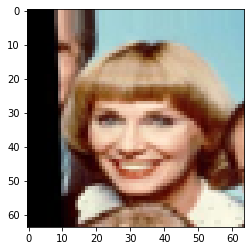

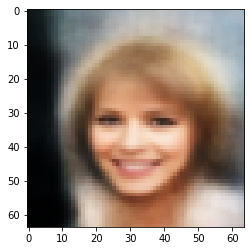

In [19]:
import matplotlib.pyplot as plt
# sample = train_dataset[random.randint(0,100000)]
sample = train_dataset[5]
sample = sample.reshape(1,3,64,64) #2. * x/255. - 1.

sample_ori = np.array(sample[0].permute(1,2,0))
sample_ori = (sample_ori + 1)/2*255
plt.imshow(sample_ori.astype(np.uint8))
plt.show()

model.eval()
with torch.no_grad():
    img = sample.cuda()
            
    if model_type in ['res']:
        output = model(img)
        output = decoder(output)
        output = output[0]
        
    if model_type in ['fcn']:
        img = img.reshape(img.shape[0], -1)
        x = model.encoder(img)
        x[0][2] = x[0][2]*3
        output = model.decoder(x)
        output = output.reshape(3,64,64)
        
    if model_type in ['vae']:
        output = model(img)
        output = output[0][0]
        
    if model_type in ['cnn']:
        output = model(img)[0]
    
    output = output.cpu().permute(1,2,0)    
    output = np.array(output)
    output = (output + 1)/2*255
    plt.imshow(output.astype(np.uint8))
    

In [16]:
# import matplotlib.pyplot as plt
# for i in range(100):
#     sample = test_dataset[i]
#     sample = sample.reshape(1,3,64,64) #2. * x/255. - 1.

#     sample_ori = np.array(sample[0].permute(1,2,0))
#     sample_ori = (sample_ori + 1)/2*255
#     plt.imshow(sample_ori.astype(np.uint8))
#     plt.show()

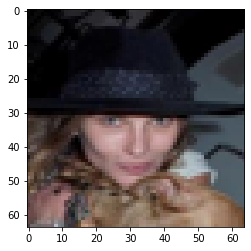

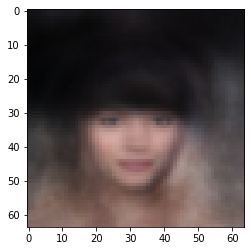

In [17]:
import matplotlib.pyplot as plt
sample = test_dataset[20]
sample = sample.reshape(1,3,64,64) #2. * x/255. - 1.

sample_ori = np.array(sample[0].permute(1,2,0))
sample_ori = (sample_ori + 1)/2*255
plt.imshow(sample_ori.astype(np.uint8))
plt.show()

model.eval()
with torch.no_grad():
    img = sample.cuda()
    if model_type in ['fcn']:
        img = img.reshape(img.shape[0], -1)
        x = model.encoder(img)
        x[0][0] = x[0][0]*3
        output = model.decoder(x)
        output = output.reshape(3,64,64)
    if model_type in ['vae']:
        output = model(img)
        output = output[0][0]
    if model_type in ['cnn']:
        output = model(img)[0]
    
    output = output.cpu().permute(1,2,0)    
    output = np.array(output)
    output = (output + 1)/2*255
    plt.imshow(output.astype(np.uint8))
    

In [18]:
anomality = list()
with torch.no_grad():
  for i, data in enumerate(test_dataloader):
    img = data.float().cuda()
    if model_type in ['fcn']:
      img = img.view(img.shape[0], -1)
    output = model(img)
    if model_type in ['vae']:
      output = output[0]
    if model_type in ['fcn']:
        loss = eval_loss(output, img).sum(-1)
    else:
        loss = eval_loss(output, img).sum([1, 2, 3])
    anomality.append(loss)
anomality = torch.cat(anomality, axis=0)
anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy()
print(out_file)
df = pd.DataFrame(anomality, columns=['score'])
df.to_csv(out_file, index_label = 'ID')

prediction40.csv
